/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

--- Ensemble Evaluation Metrics (file2.csv) ---
Accuracy: 0.9770
F1 Score: 0.5577
Precision: 0.8056
Recall: 0.4265
Specificity: 0.9964
AUC: 0.9726
Log Loss: 0.0595
MCC: 0.5764
Kappa: 0.5470
Misclassification Error: 0.0230


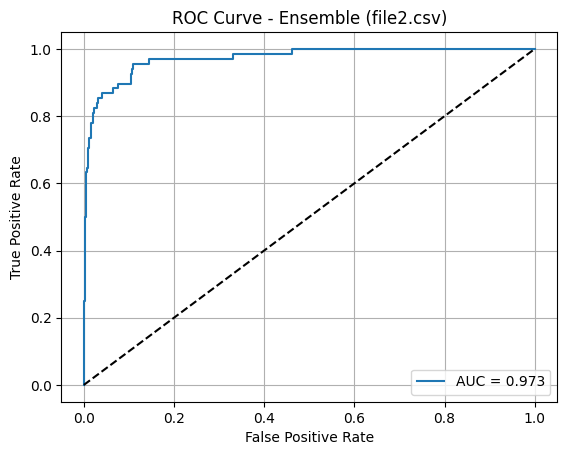

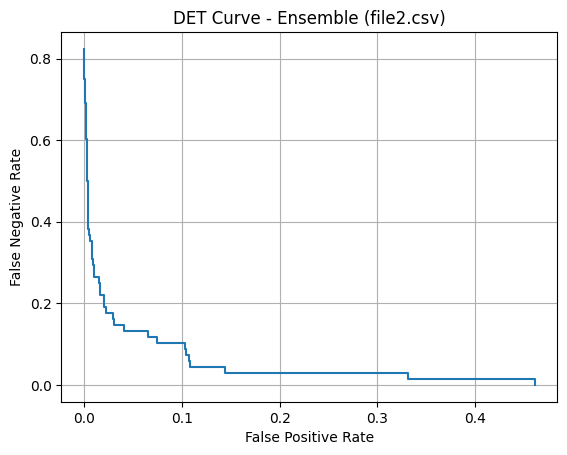

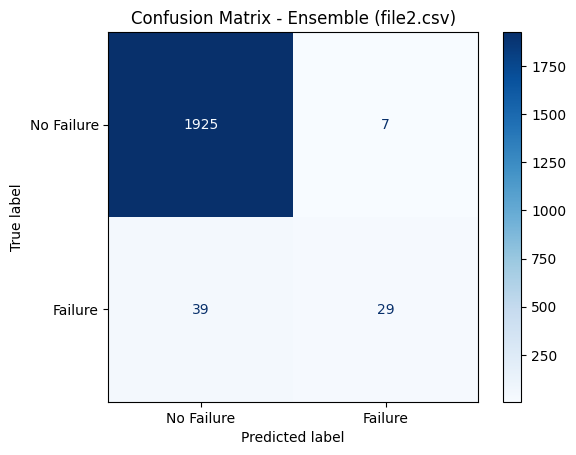

In [1]:
# Ensemble Learning on file2.csv using MLP, LSTM, CNN+BiGRU

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, log_loss, matthews_corrcoef, cohen_kappa_score,
    roc_curve, det_curve, ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Model as KerasModel

# STEP 1: Load and Prepare Data
df = pd.read_csv("file2.csv")
df.drop(columns=["UDI", "Product ID", "TWF", "HDF", "PWF", "OSF", "RNF"], inplace=True)

X = df.drop(columns=["Machine failure"])
y = df["Machine failure"]

# STEP 2: Preprocessing
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)

X_train_seq = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_seq = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# STEP 3: Define Models

def build_mlp(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(32, input_shape=input_shape),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

def build_cnn_bigru(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Bidirectional(LSTM(32))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    return KerasModel(inputs, outputs)

# STEP 4: Train Function
def train_model(model, X_train, y_train):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=0
    )
    return model

mlp_model = train_model(build_mlp(X_train.shape[1]), X_train, y_train)
lstm_model = train_model(build_lstm(X_train_seq.shape[1:]), X_train_seq, y_train)
cnn_bigrugru_model = train_model(build_cnn_bigru(X_train_seq.shape[1:]), X_train_seq, y_train)

# STEP 5: Ensemble Predictions
mlp_proba = mlp_model.predict(X_test).ravel()
lstm_proba = lstm_model.predict(X_test_seq).ravel()
cnn_bigrugru_proba = cnn_bigrugru_model.predict(X_test_seq).ravel()

ensemble_proba = (mlp_proba + lstm_proba + cnn_bigrugru_proba) / 3
ensemble_pred = (ensemble_proba >= 0.5).astype(int)

# STEP 6: Evaluation
cm = confusion_matrix(y_test, ensemble_pred)
tn, fp, fn, tp = cm.ravel()

metrics = {
    "Accuracy": accuracy_score(y_test, ensemble_pred),
    "F1 Score": f1_score(y_test, ensemble_pred),
    "Precision": precision_score(y_test, ensemble_pred),
    "Recall": recall_score(y_test, ensemble_pred),
    "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
    "AUC": roc_auc_score(y_test, ensemble_proba),
    "Log Loss": log_loss(y_test, ensemble_proba),
    "MCC": matthews_corrcoef(y_test, ensemble_pred),
    "Kappa": cohen_kappa_score(y_test, ensemble_pred),
    "Misclassification Error": (fp + fn) / (tp + tn + fp + fn)
}

print("\n--- Ensemble Evaluation Metrics (file2.csv) ---")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

# STEP 7: Plots
fpr, tpr, _ = roc_curve(y_test, ensemble_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {metrics['AUC']:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve - Ensemble (file2.csv)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

fpr, fnr, _ = det_curve(y_test, ensemble_proba)
plt.figure()
plt.plot(fpr, fnr, label="DET Curve")
plt.title("DET Curve - Ensemble (file2.csv)")
plt.xlabel("False Positive Rate")
plt.ylabel("False Negative Rate")
plt.grid()
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, ensemble_pred, display_labels=["No Failure", "Failure"], cmap="Blues")
plt.title("Confusion Matrix - Ensemble (file2.csv)")
plt.grid(False)
plt.show()
